In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

file = "datasets/neutrino/bnb_WithWire_00.h5"

with h5py.File(file, "r") as f:
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"[dataset] {name}, shape={obj.shape}, dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"[group]   {name}")
    f.visititems(print_structure)

[group]   edep_table
[dataset] edep_table/energy, shape=(973691, 1), dtype=float32
[dataset] edep_table/energy_fraction, shape=(973691, 1), dtype=float32
[dataset] edep_table/event_id, shape=(973691, 3), dtype=int32
[dataset] edep_table/event_id.seq_cnt, shape=(879, 2), dtype=int64
[dataset] edep_table/g4_id, shape=(973691, 1), dtype=int32
[dataset] edep_table/hit_id, shape=(973691, 1), dtype=int32
[group]   event_table
[dataset] event_table/event_id, shape=(1085, 3), dtype=int32
[dataset] event_table/event_id.seq_cnt, shape=(1085, 2), dtype=int64
[dataset] event_table/is_cc, shape=(1085, 1), dtype=int32
[dataset] event_table/lep_energy, shape=(1085, 1), dtype=float32
[dataset] event_table/nu_dir, shape=(1085, 3), dtype=float32
[dataset] event_table/nu_energy, shape=(1085, 1), dtype=float32
[dataset] event_table/nu_pdg, shape=(1085, 1), dtype=int32
[dataset] event_table/nu_vtx, shape=(1085, 3), dtype=float32
[dataset] event_table/nu_vtx_corr, shape=(1085, 3), dtype=float32
[dataset] ev

In [2]:
def plot_evt_sig_bkg_via_changes(h5path, evt_idx=1, plane=2, t_ds=6, w_ds=1,
                                 style="coolwarm", vmax_abs=1,
                                 jet_vmin=0, jet_vmax=100, jet_cmap="jet",
                                 overlay=None,
                                 point_size=6, alpha=0.6):
    def changepoint_index(eid_array):
        change = np.any(eid_array[1:] != eid_array[:-1], axis=1)
        starts = np.concatenate(([0], np.where(change)[0] + 1)).astype(np.int64)
        lengths = np.diff(np.concatenate((starts, [len(eid_array)]))).astype(np.int64)
        eids = [tuple(eid_array[s]) for s in starts]
        return starts, lengths, eids

    def build_table_index_by_changes(f, table):
        eid_all = f[f"{table}/event_id"][:]
        starts, lengths, eids = changepoint_index(eid_all)
        eid2slice = {eid: (int(s), int(c)) for eid, s, c in zip(eids, starts, lengths)}
        return (starts, lengths, eids, eid2slice)

    def downsample_time(img, factor):
        n_w, n_t = img.shape
        trim = n_t % factor
        if trim: img = img[:, :n_t - trim]
        img = img.reshape(n_w, -1, factor).sum(axis=2)
        if factor > 1:
            lo = 10 * factor / 6
            hi = 100 * factor / 6
            img = np.where(img < lo, 0, img)
            img = np.clip(img, 0, hi)
        return img

    def downsample_wire(img, factor):
        n_w, n_t = img.shape
        trim = n_w % factor
        if trim: img = img[:n_w - trim, :]
        img = img.reshape(-1, factor, n_t).sum(axis=1)
        if factor > 1:
            lo = 10 * factor / 6
            hi = 100 * factor / 6
            img = np.where(img < lo, 0, img)
            img = np.clip(img, 0, hi)
        return img

    def robust_normalize_per_wire(img, empty_thresh=0.0):
        med = np.median(img, axis=1, keepdims=True)
        mad = np.median(np.abs(img - med), axis=1, keepdims=True) + 1e-6
        z = (img - med) / (3.0 * mad)
        z = np.clip(z, -1.0, 1.0)
        z[img <= empty_thresh] = 0.0
        return z

    # auto overlay default
    if overlay is None:
        overlay = (style.lower() == "coolwarm")

    with h5py.File(h5path, "r") as f:
        # event order from wire_table change-points
        w_starts, w_lengths, w_eids, _ = build_table_index_by_changes(f, "wire_table")
        if not (0 <= evt_idx < len(w_eids)):
            raise IndexError(f"evt_idx out of range 0..{len(w_eids)-1}")
        eid = w_eids[evt_idx]
        w_s, w_c = int(w_starts[evt_idx]), int(w_lengths[evt_idx])

        # build image for this event/plane (sorted by local_wire)
        lp = f["wire_table/local_plane"][w_s:w_s+w_c, 0]
        lw = f["wire_table/local_wire"][w_s:w_s+w_c, 0].astype(np.int64)
        adc = f["wire_table/adc"][w_s:w_s+w_c, :]
        rows_plane = (lp == plane)
        plane_adc = adc[rows_plane]
        plane_wire = lw[rows_plane]
        order = np.argsort(plane_wire)
        plane_wire = plane_wire[order]
        plane_adc = plane_adc[order, :]

        # downsample
        img = downsample_time(plane_adc, factor=t_ds)
        img = downsample_wire(img, factor=w_ds)

        if style.lower() == "coolwarm":
            img_disp = robust_normalize_per_wire(img, empty_thresh=0.0)
            cmap, vmin, vmax = "coolwarm", -vmax_abs, vmax_abs
            cbar_label = "normalized ADC"
        elif style.lower() == "jet":
            img_disp = img
            cmap, vmin, vmax = jet_cmap, jet_vmin, jet_vmax
            cbar_label = "ADC sum"

        # optional overlays (skip all hit/edep work if overlay==False)
        x_wire = y_time = is_signal = np.array([])
        if overlay:
            _, _, _, h_map = build_table_index_by_changes(f, "hit_table")
            _, _, _, e_map = build_table_index_by_changes(f, "edep_table")
            if eid in h_map:
                hs, hc = h_map[eid]
                hit_id = f["hit_table/hit_id"][hs:hs+hc, 0]
                hit_lp = f["hit_table/local_plane"][hs:hs+hc, 0]
                hit_lw = f["hit_table/local_wire"][hs:hs+hc, 0].astype(np.int64)
                hit_time = f["hit_table/local_time"][hs:hs+hc, 0]

                sig_ids = set()
                if eid in e_map:
                    es, ec = e_map[eid]
                    if ec > 0:
                        sig_ids = set(f["edep_table/hit_id"][es:es+ec, 0].tolist())

                is_signal_full = np.isin(hit_id, list(sig_ids)) if sig_ids else np.zeros_like(hit_id, dtype=bool)

                # keep only this plane and map to displayed wires
                mask = (hit_lp == plane) & np.isin(hit_lw, plane_wire)
                hit_lw = hit_lw[mask]
                hit_time = hit_time[mask]
                is_signal = is_signal_full[mask]

                wire_to_row = {int(w): i for i, w in enumerate(plane_wire)}
                rows_img = np.fromiter((wire_to_row[int(w)] for w in hit_lw), dtype=np.int64, count=hit_lw.size)
                x_wire = (rows_img // w_ds).astype(int)
                y_time = (np.rint(hit_time).astype(int) // t_ds).clip(0, img.shape[1]-1)

    if overlay:
        print(f"EID={eid} | evt_idx={evt_idx} | plane={plane} | "
              f"signal hits / total hits = {int(is_signal.sum())} / {is_signal.size}")
    else:
        print(f"EID={eid} | evt_idx={evt_idx} | plane={plane}")

    plt.figure(figsize=(15, 6))
    im = plt.imshow(img_disp.T, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(im)
    cb.set_label(cbar_label)
    plt.title(f"EID={eid} | plane={plane}  (time down x{t_ds}, wire down x{w_ds})")
    plt.xlabel("wire")
    plt.ylabel("time")

    if overlay and x_wire.size:
        bkg = ~is_signal
        plt.scatter(x_wire[bkg], y_time[bkg], s=point_size, marker='.', linewidths=0, alpha=alpha, color='tab:blue', label='bkg hit')
        plt.scatter(x_wire[~bkg], y_time[~bkg], s=point_size, marker='.', linewidths=0, alpha=alpha, color='tab:red',  label='sig hit')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

EID=(7004, 331, 16552) | evt_idx=1 | plane=2


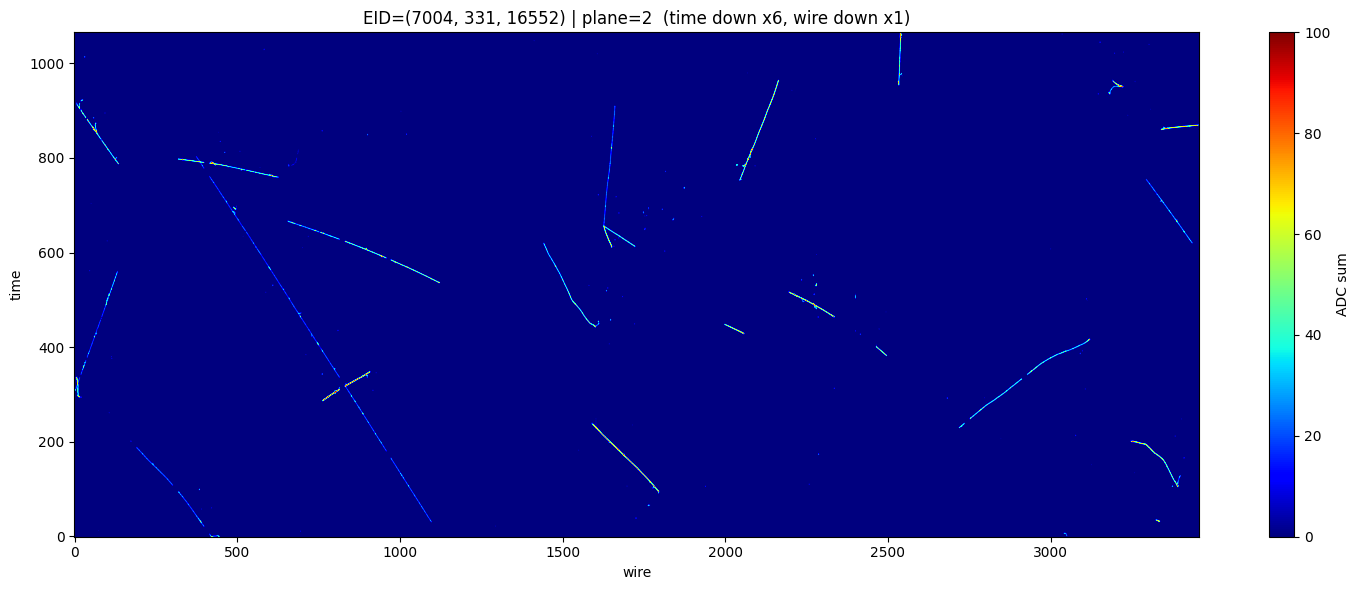

EID=(7004, 331, 16552) | evt_idx=1 | plane=2 | signal hits / total hits = 417 / 4499


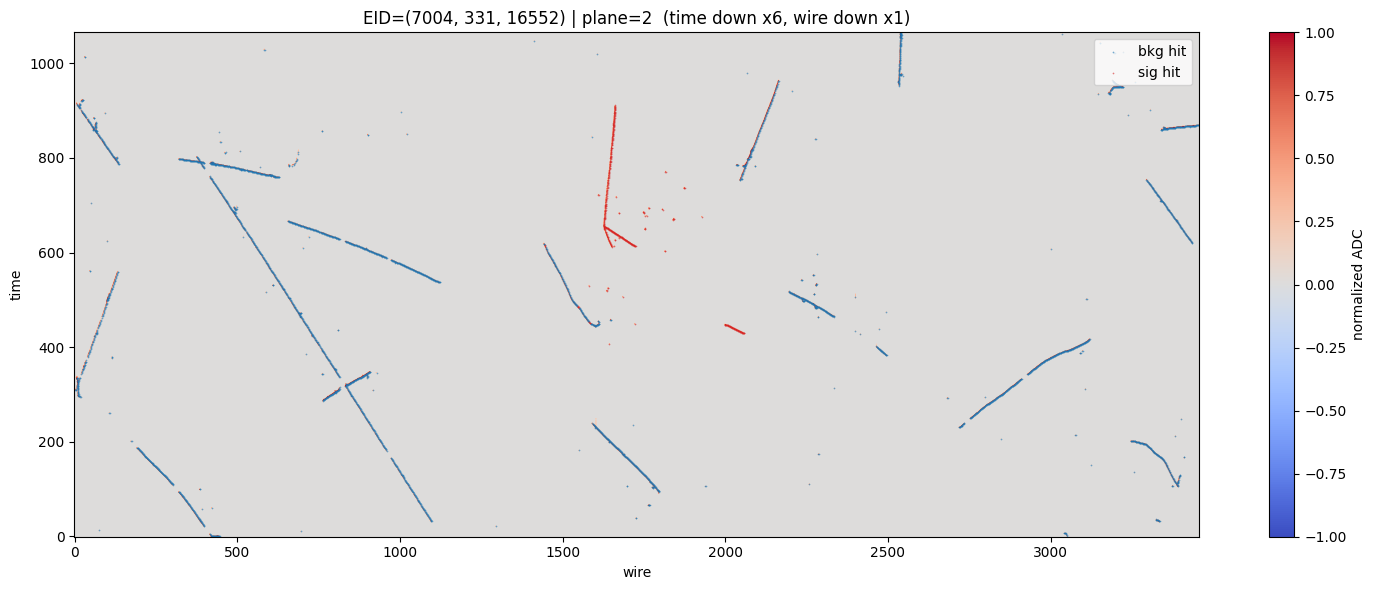

In [ ]:
plot_evt_sig_bkg_via_changes(file, evt_idx=1, plane=2, t_ds=6, w_ds=1, style="jet", jet_vmin=0, jet_vmax=100)
plot_evt_sig_bkg_via_changes(file, evt_idx=1, plane=2, t_ds=6, w_ds=1, style="coolwarm", vmax_abs=1)

EID=(7004, 331, 16591) | evt_idx=40 | plane=2


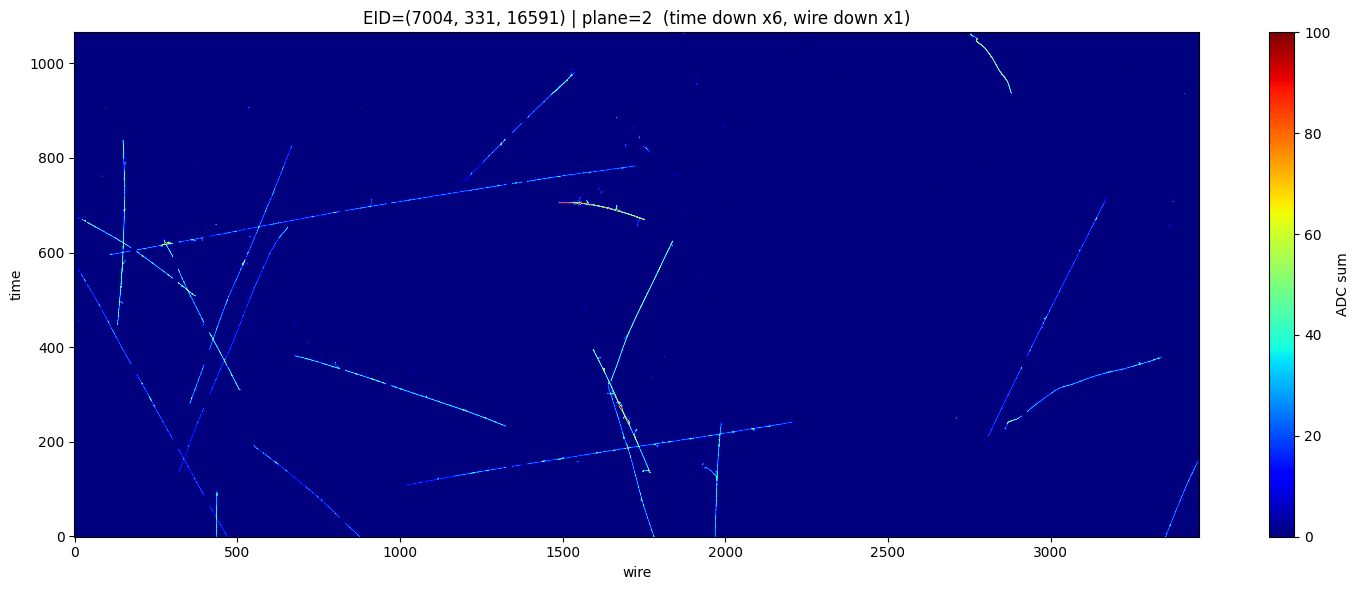

EID=(7004, 331, 16591) | evt_idx=40 | plane=2 | signal hits / total hits = 327 / 8583


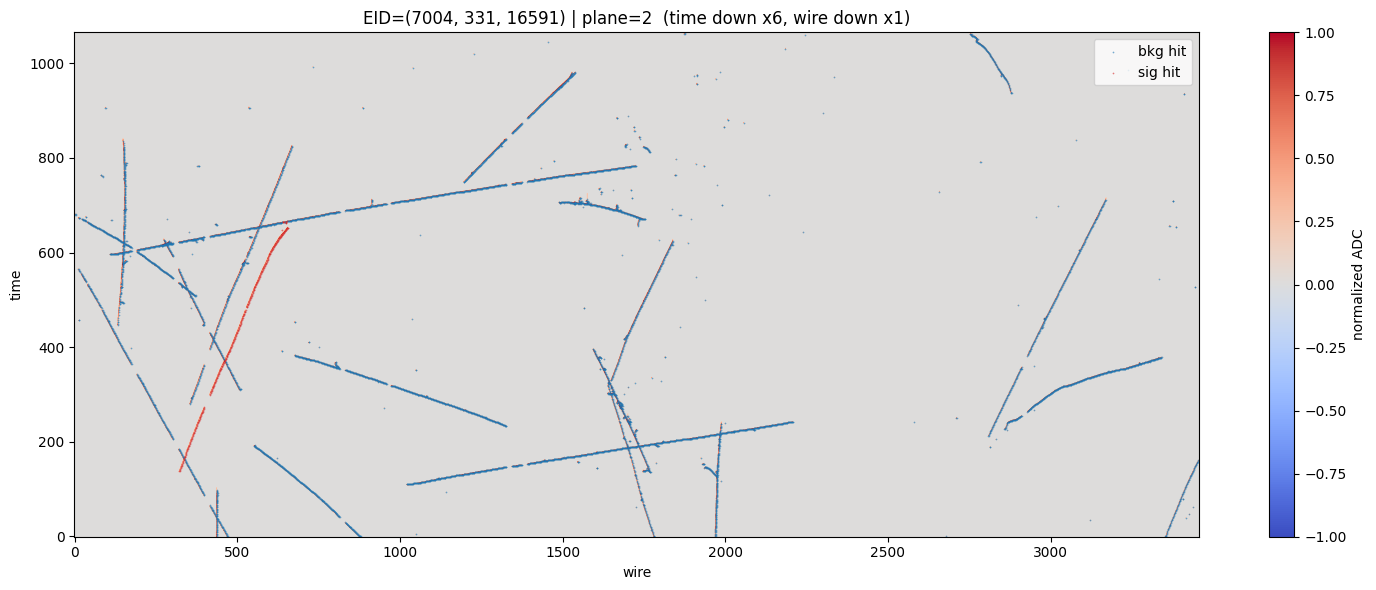

EID=(7004, 331, 16592) | evt_idx=41 | plane=2


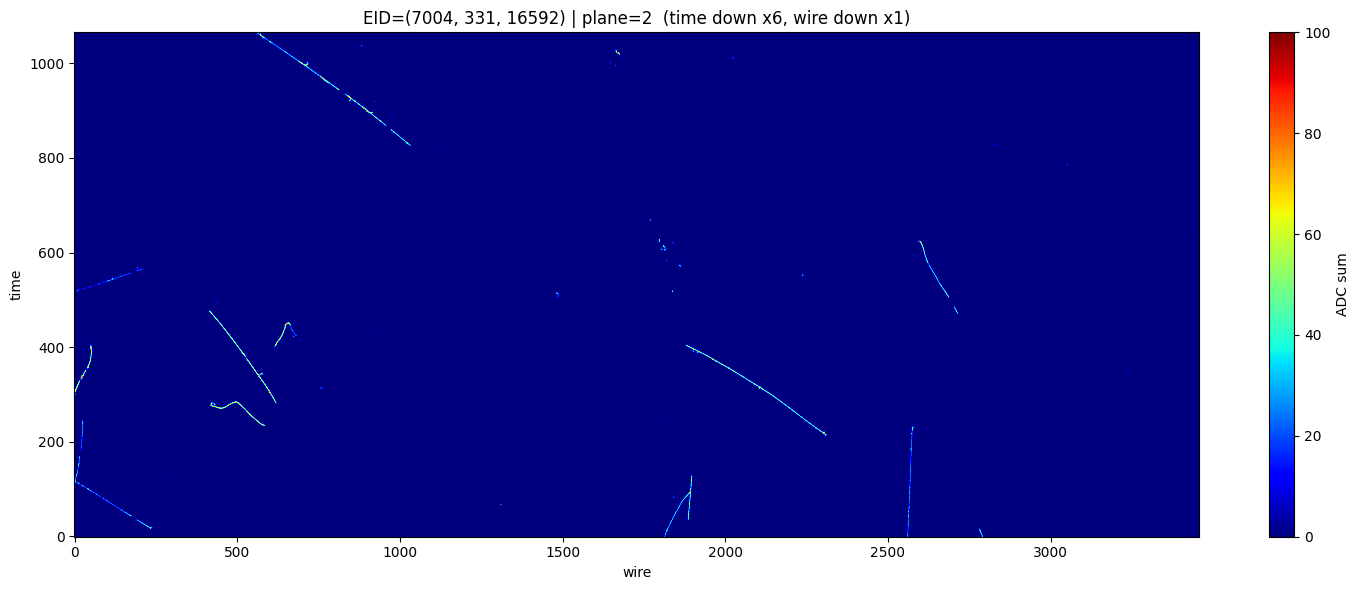

EID=(7004, 331, 16592) | evt_idx=41 | plane=2 | signal hits / total hits = 176 / 2653


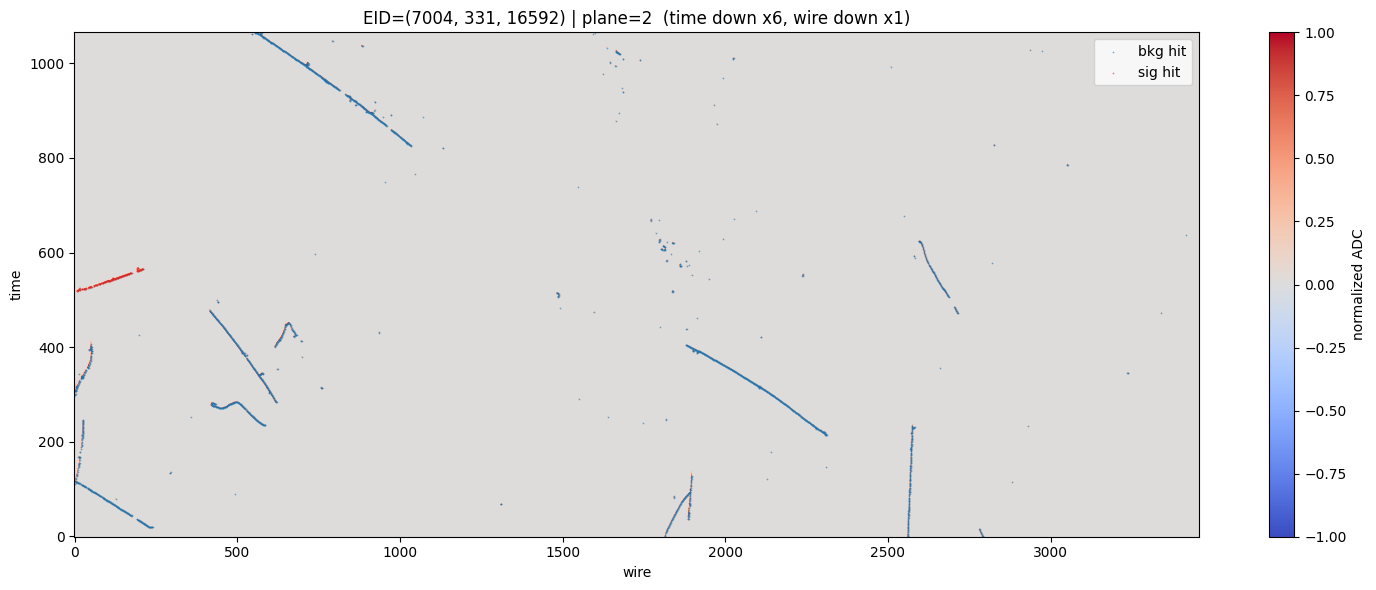

EID=(7004, 331, 16593) | evt_idx=42 | plane=2


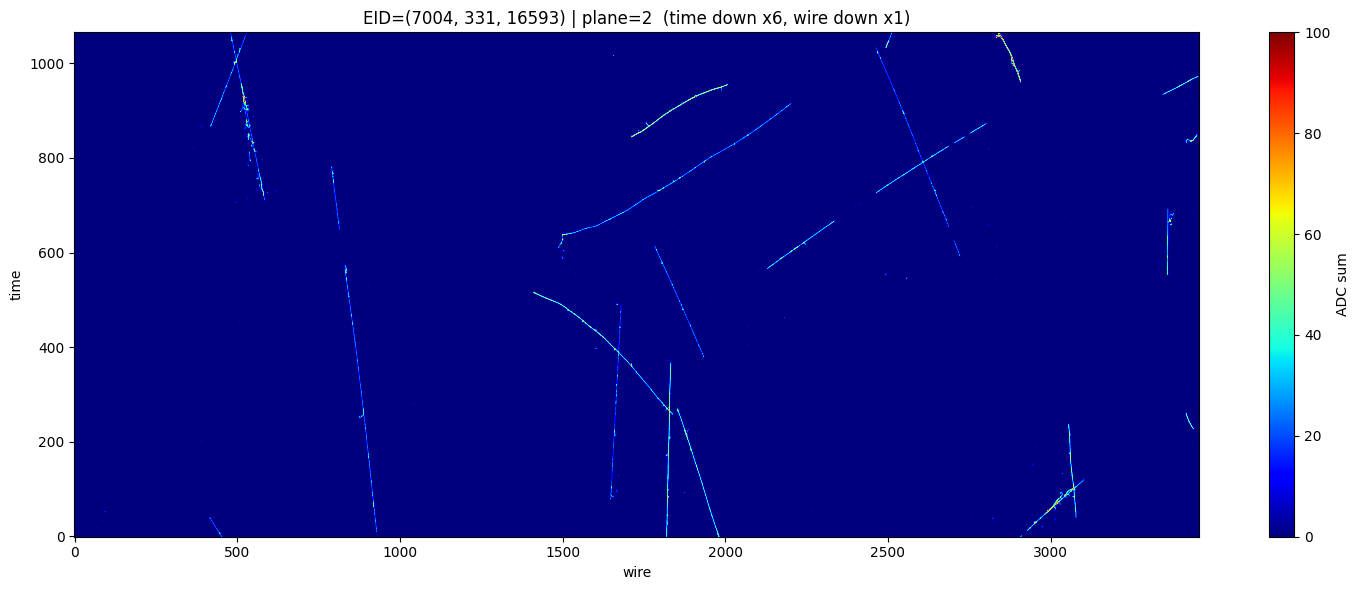

EID=(7004, 331, 16593) | evt_idx=42 | plane=2 | signal hits / total hits = 6 / 5129


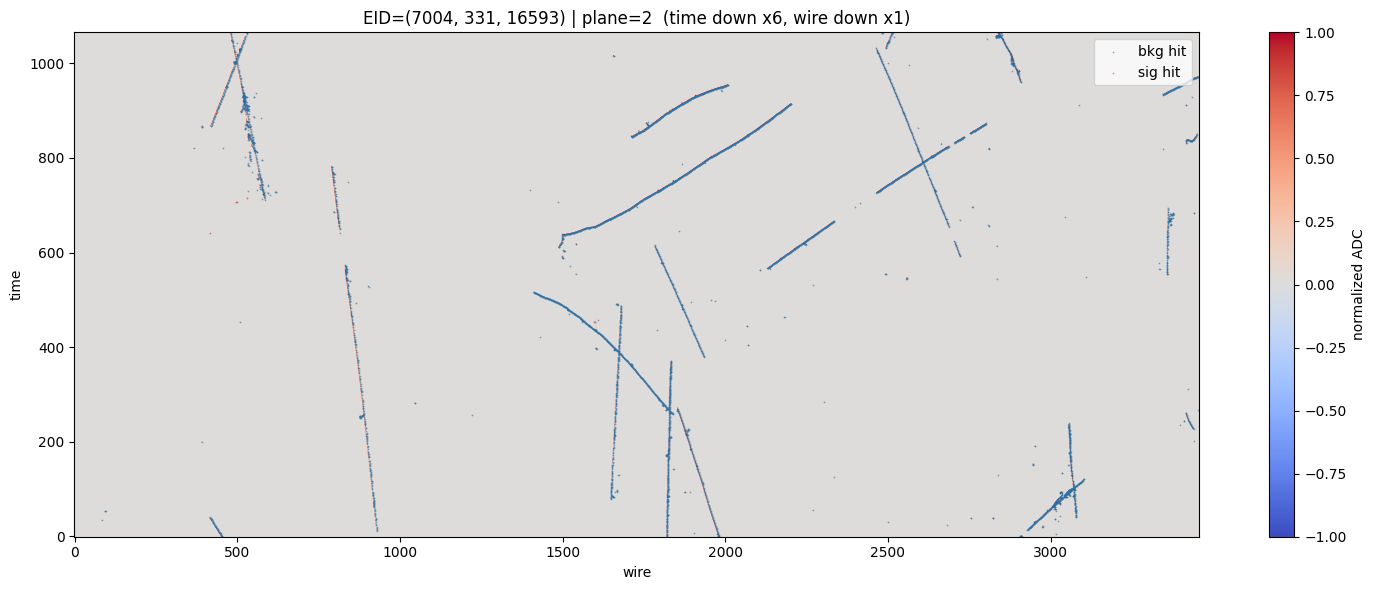

EID=(7004, 331, 16594) | evt_idx=43 | plane=2


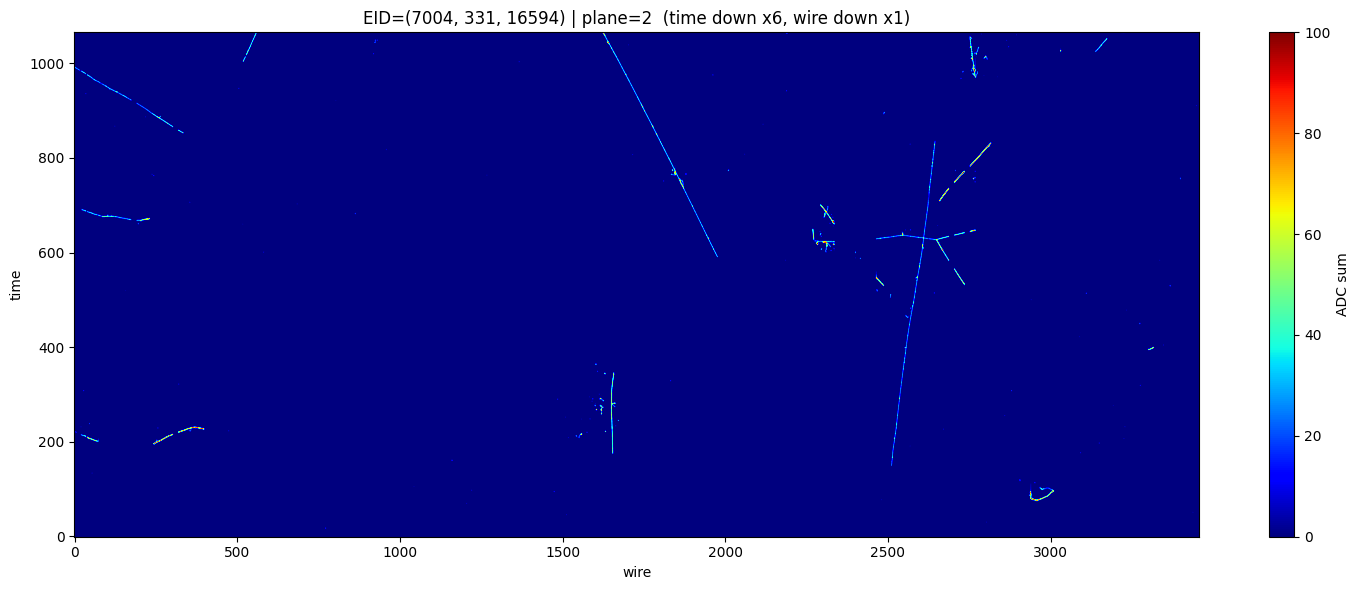

EID=(7004, 331, 16594) | evt_idx=43 | plane=2 | signal hits / total hits = 524 / 2944


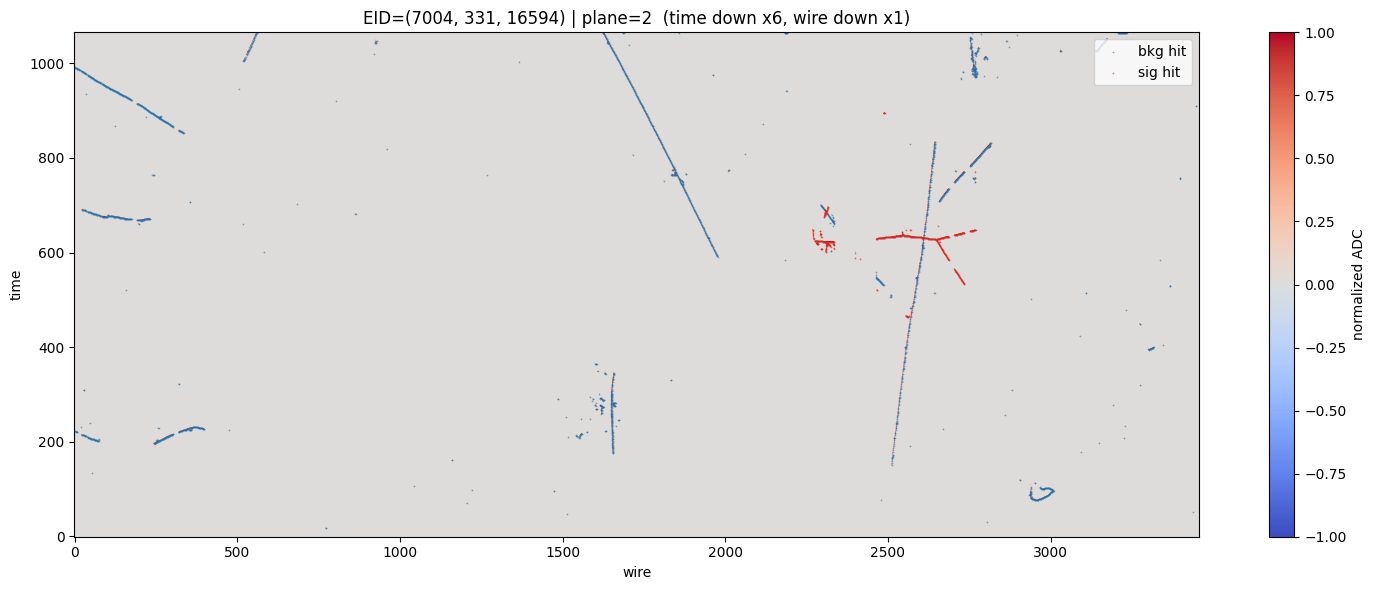

EID=(7004, 331, 16595) | evt_idx=44 | plane=2


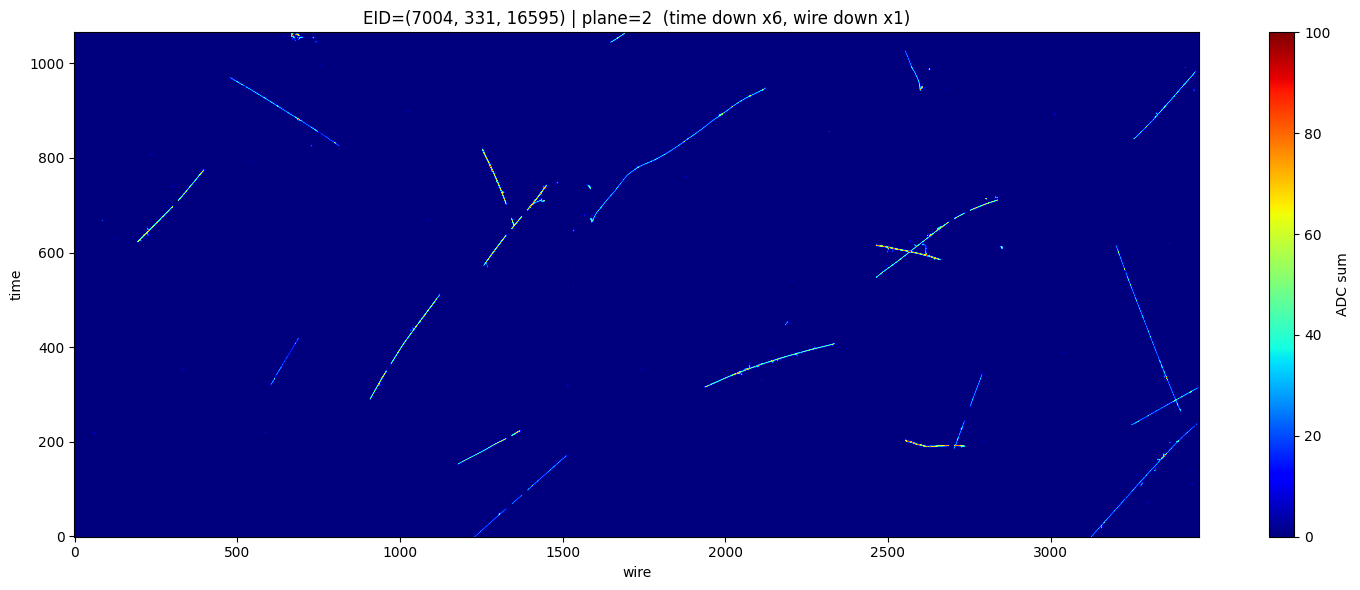

EID=(7004, 331, 16595) | evt_idx=44 | plane=2 | signal hits / total hits = 177 / 4845


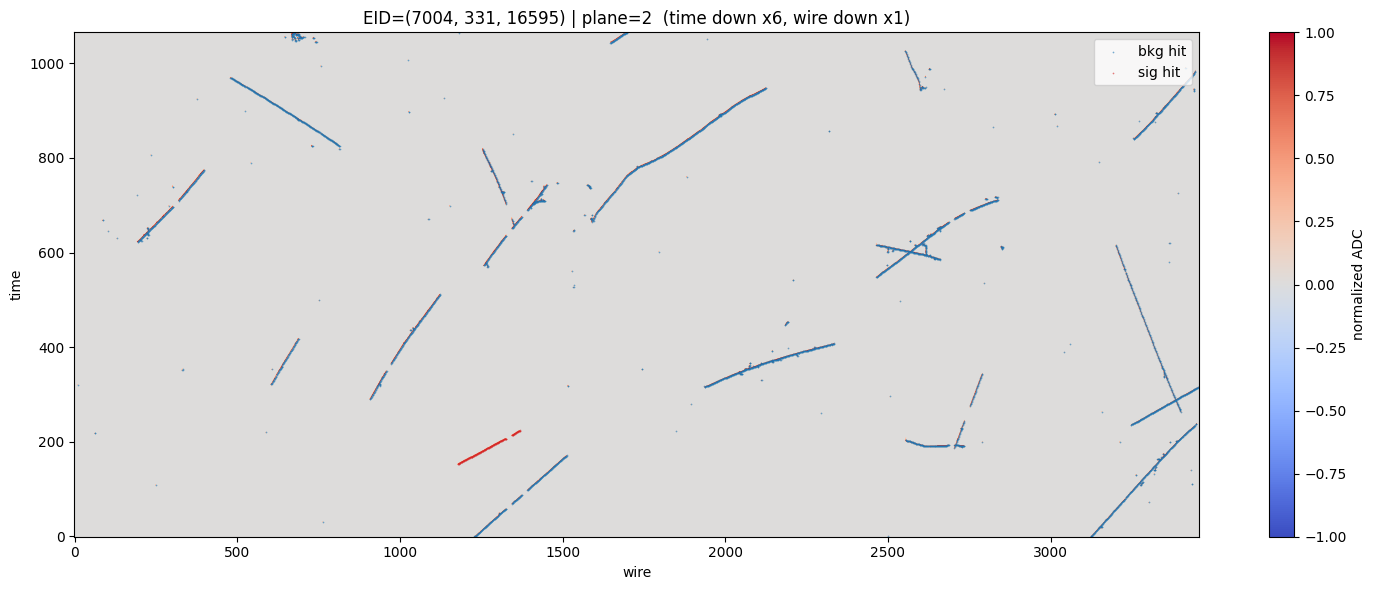

EID=(7004, 331, 16596) | evt_idx=45 | plane=2


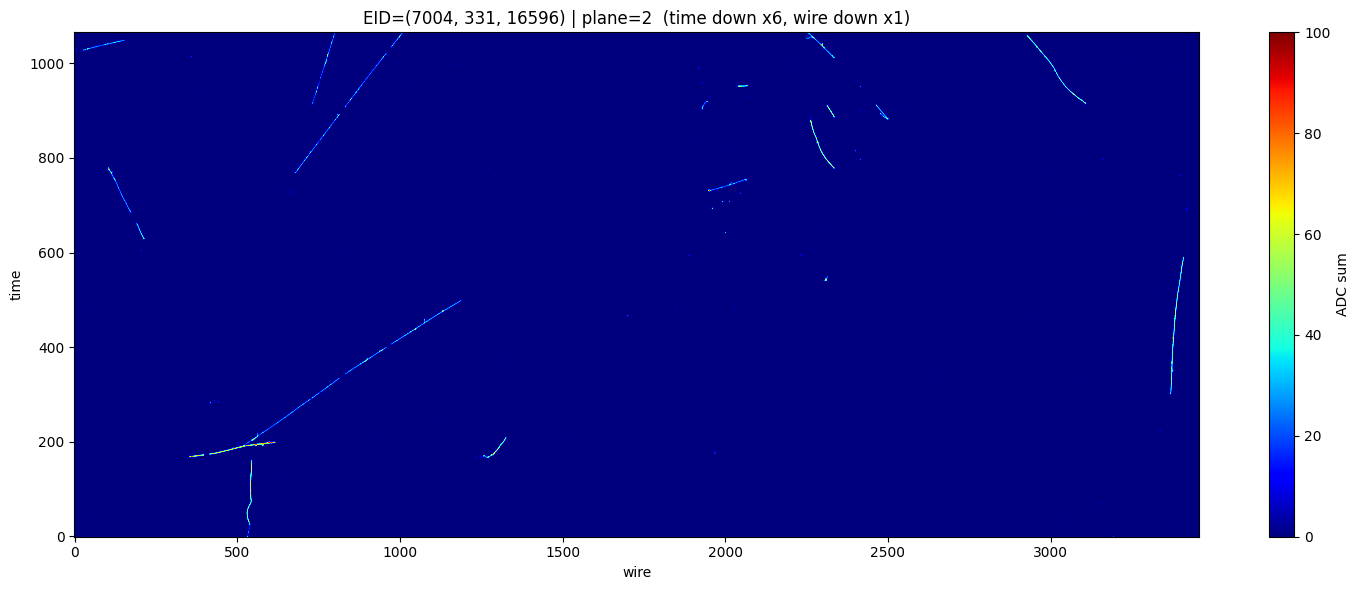

EID=(7004, 331, 16596) | evt_idx=45 | plane=2 | signal hits / total hits = 154 / 2751


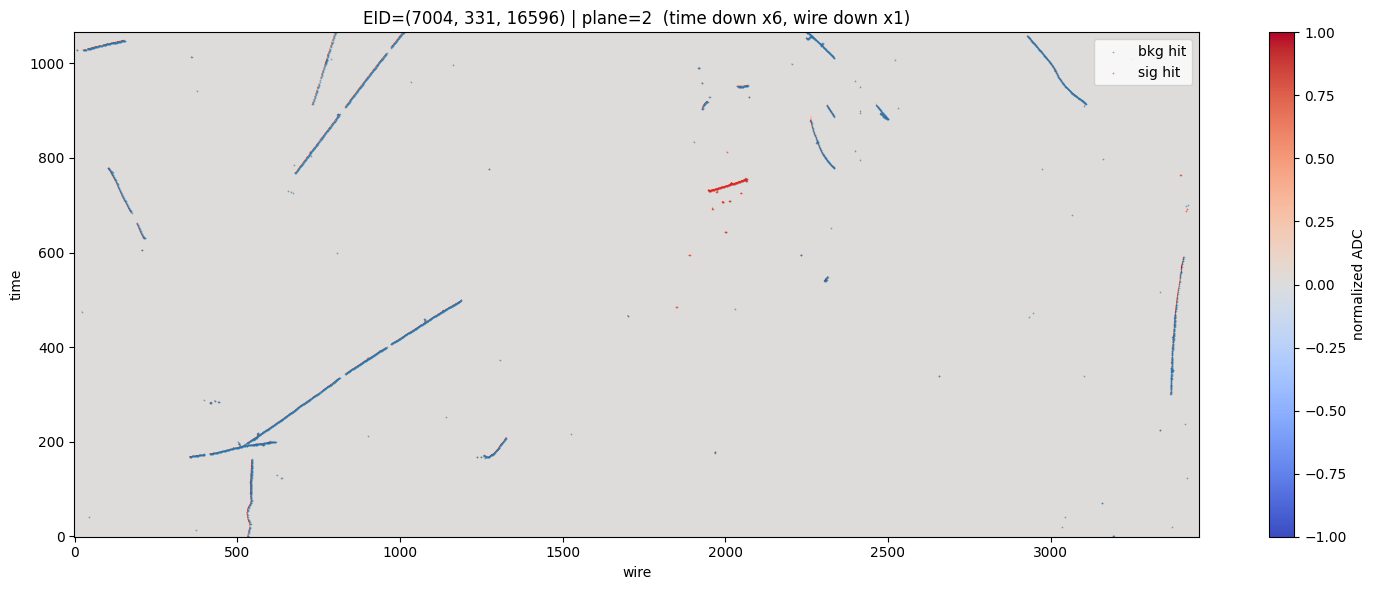

EID=(7004, 331, 16597) | evt_idx=46 | plane=2


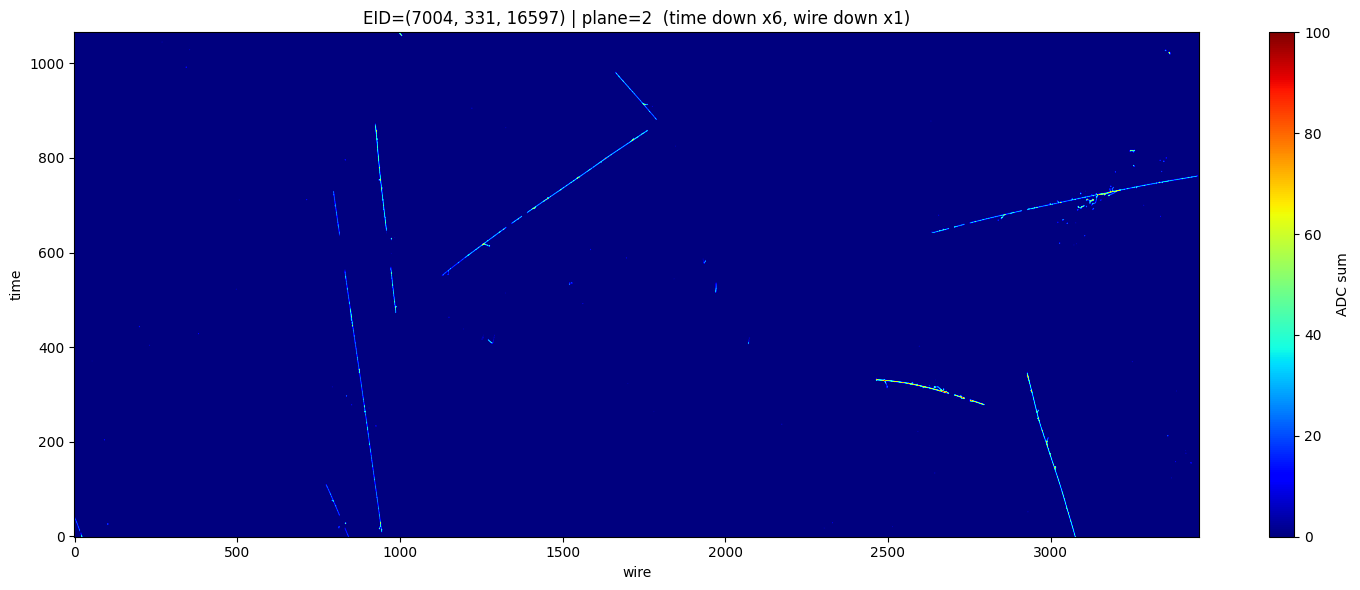

EID=(7004, 331, 16597) | evt_idx=46 | plane=2 | signal hits / total hits = 10 / 2997


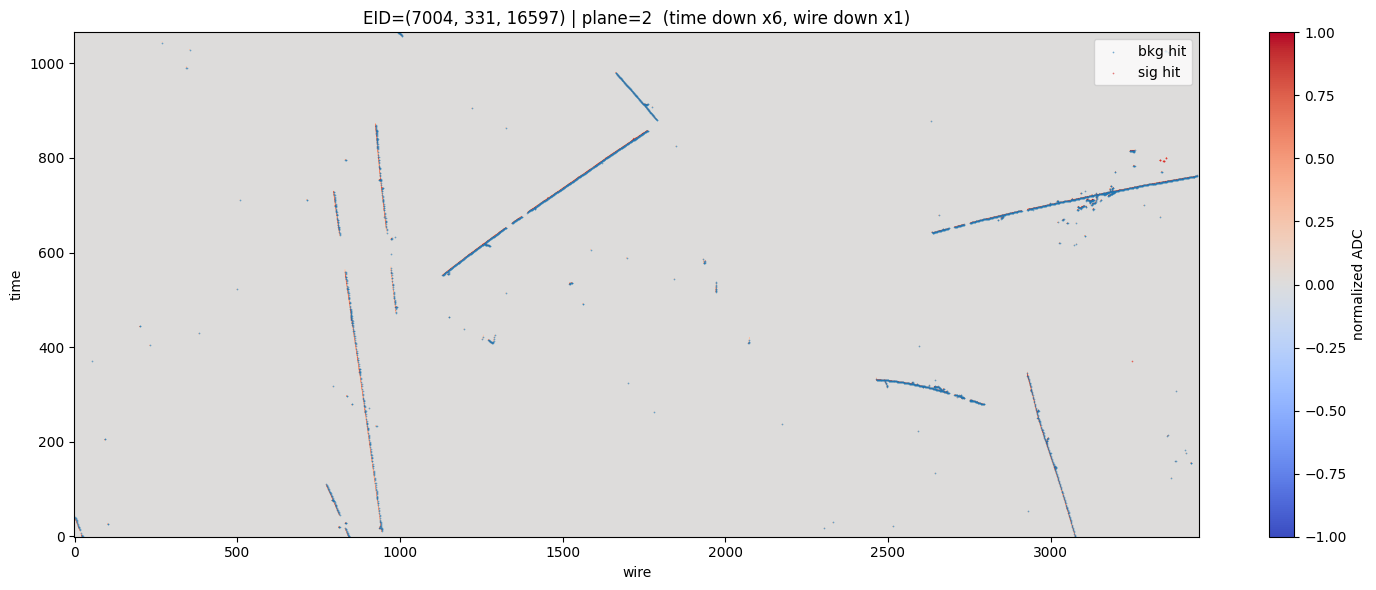

EID=(7004, 331, 16598) | evt_idx=47 | plane=2


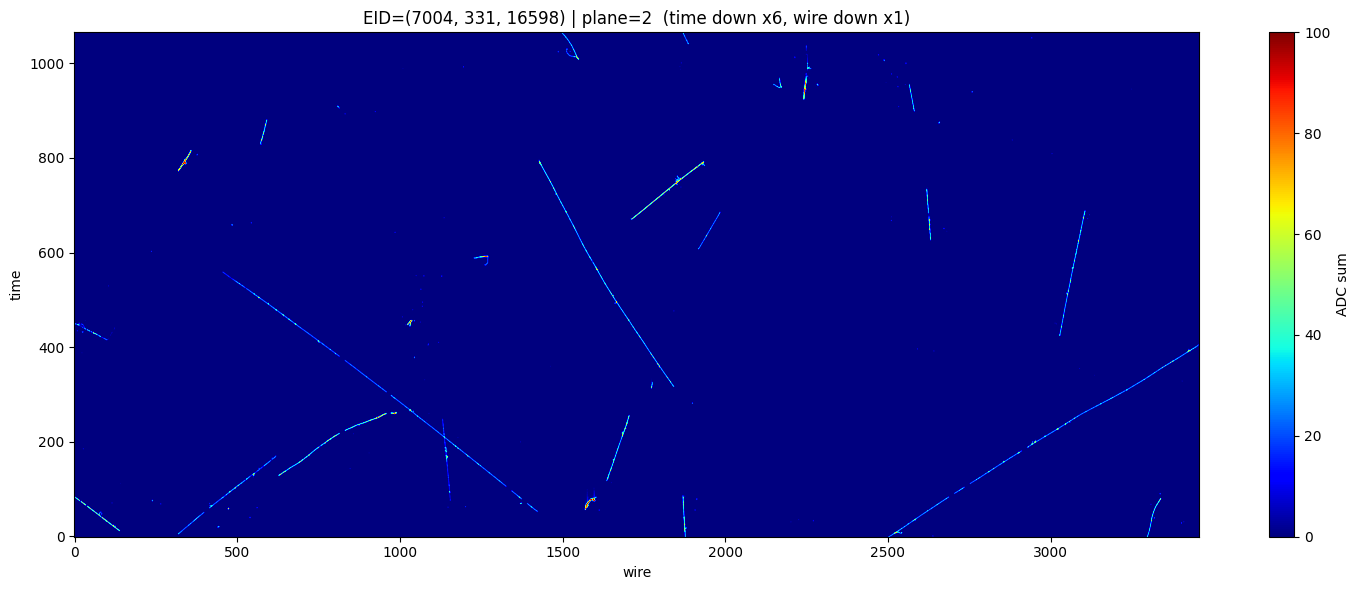

EID=(7004, 331, 16598) | evt_idx=47 | plane=2 | signal hits / total hits = 16 / 4688


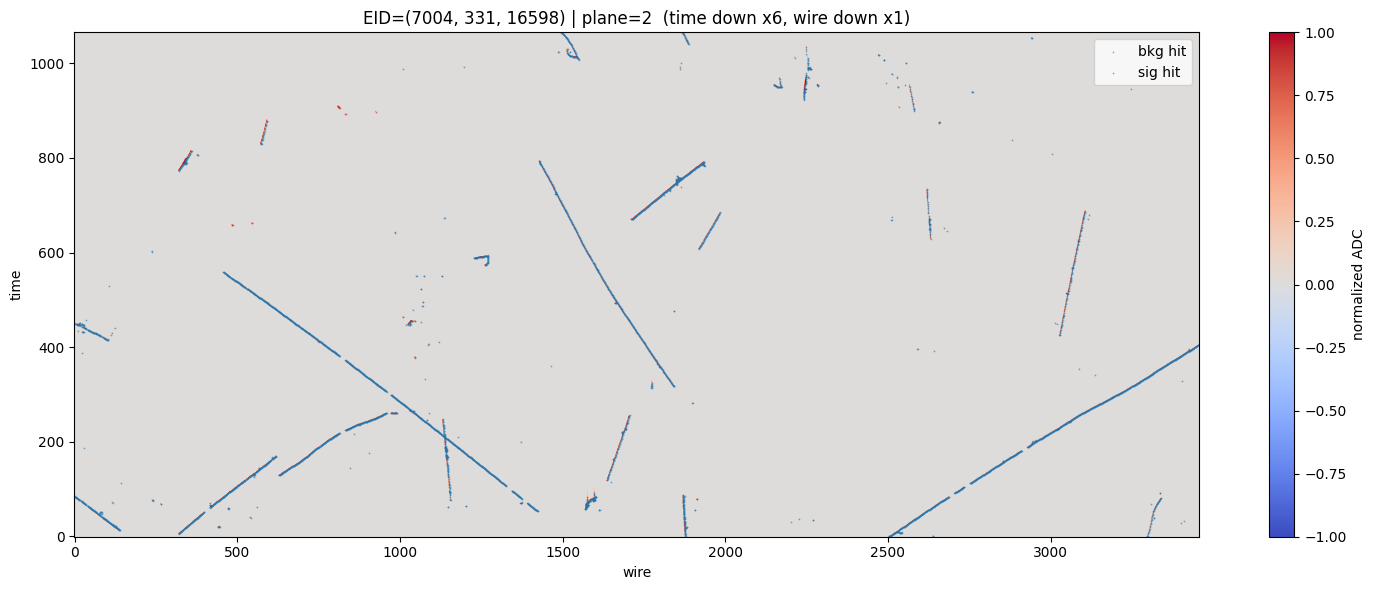

EID=(7004, 331, 16599) | evt_idx=48 | plane=2


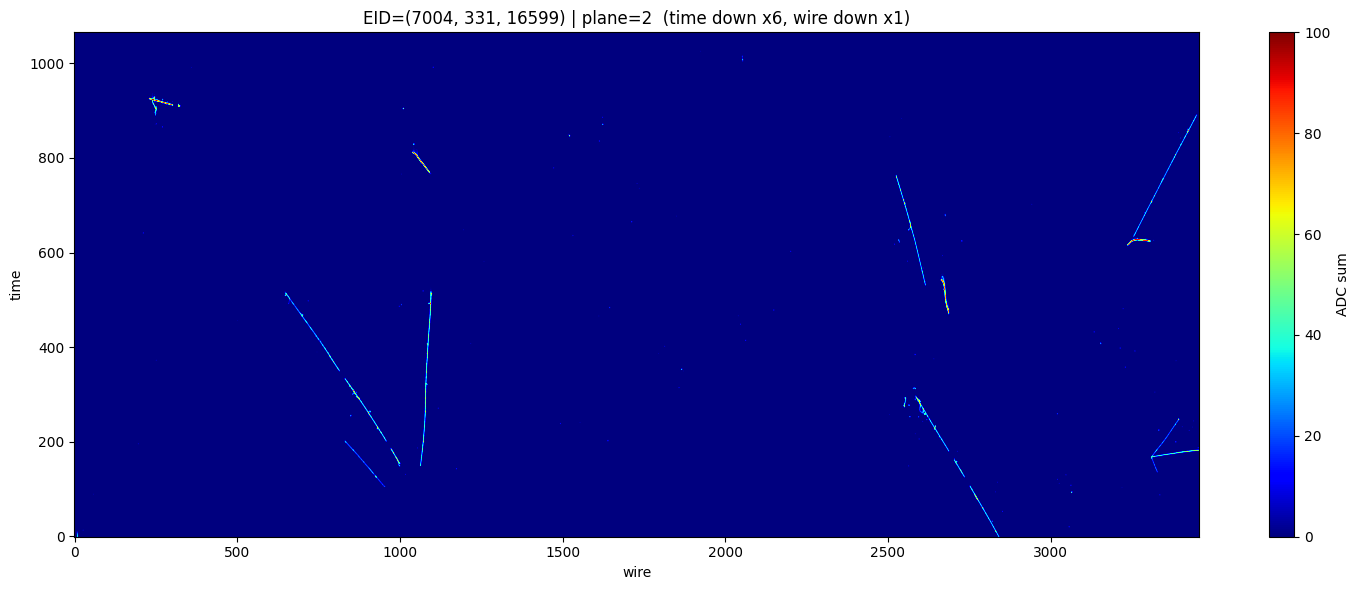

EID=(7004, 331, 16599) | evt_idx=48 | plane=2 | signal hits / total hits = 279 / 2221


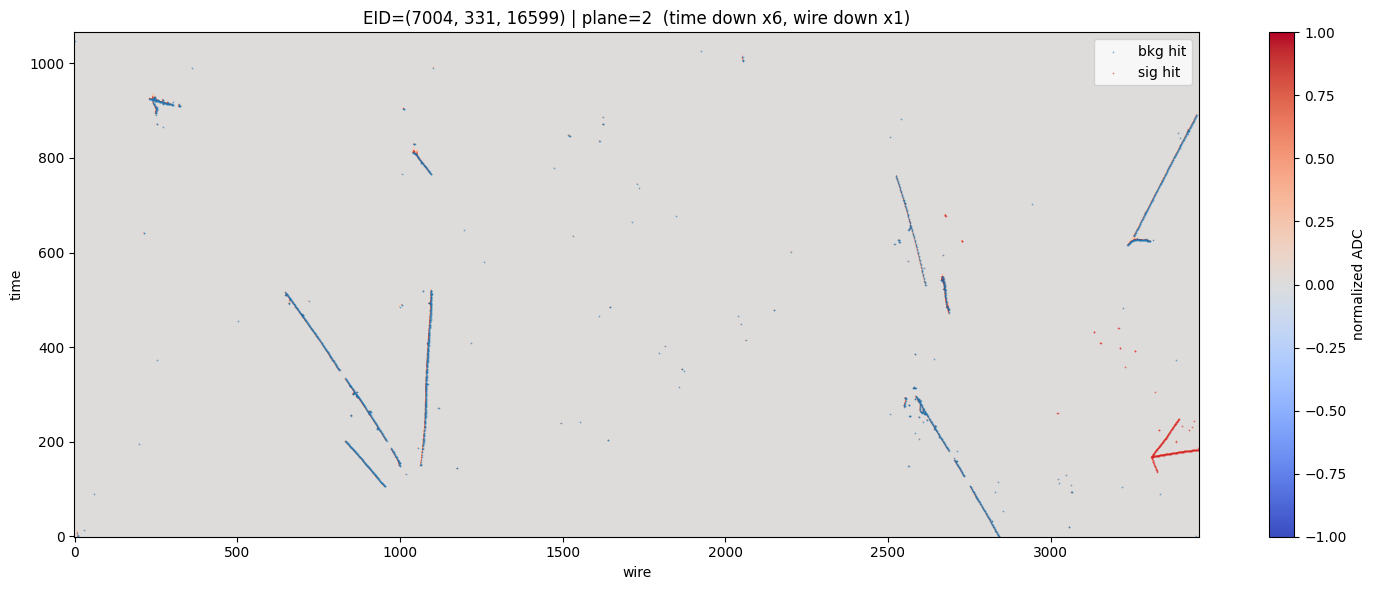

EID=(7004, 331, 16600) | evt_idx=49 | plane=2


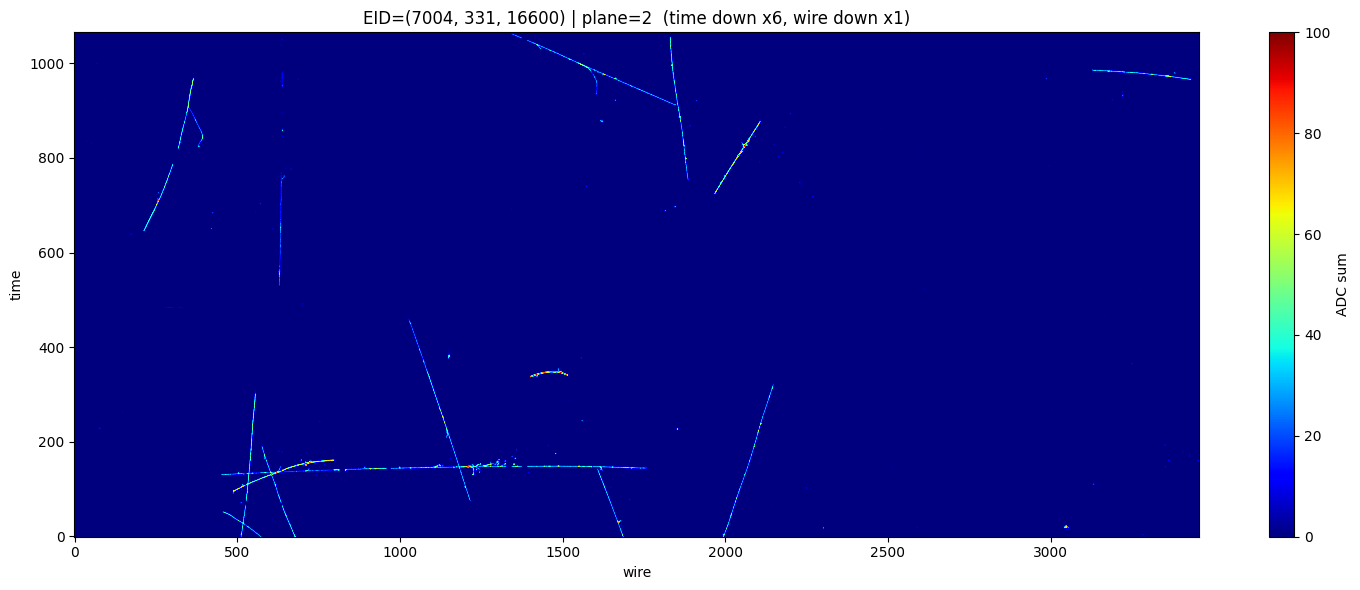

EID=(7004, 331, 16600) | evt_idx=49 | plane=2 | signal hits / total hits = 72 / 4596


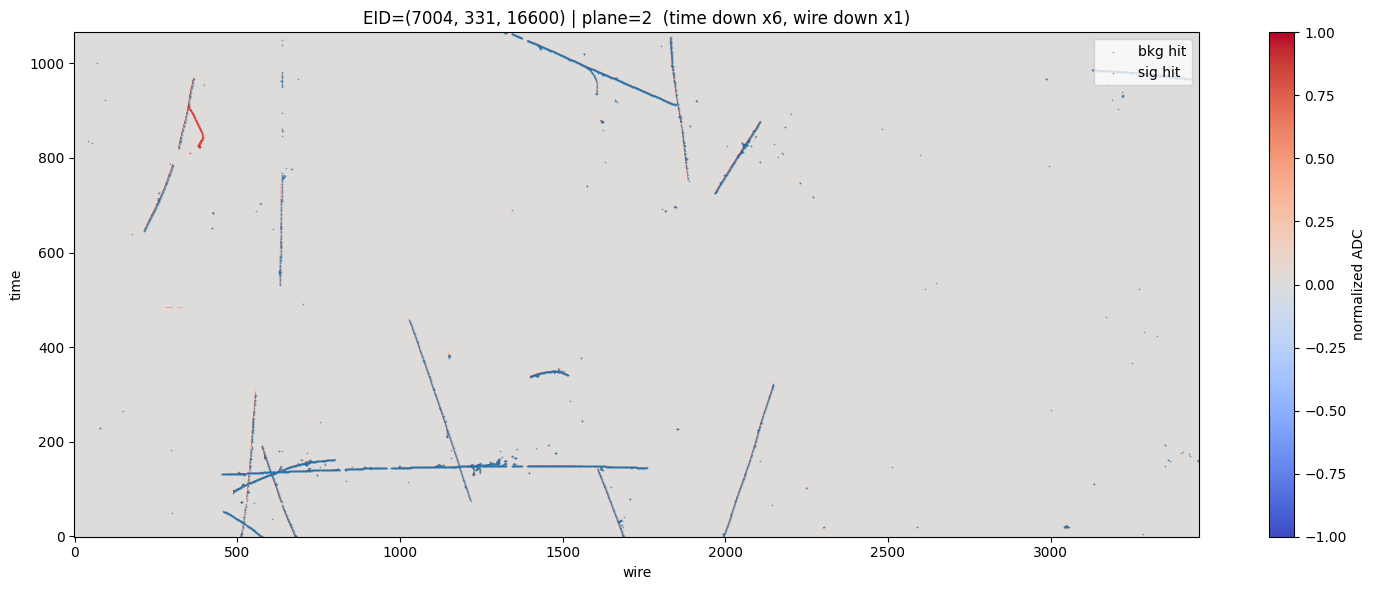

In [4]:
for i in range(40,50):
    plot_evt_sig_bkg_via_changes(file, evt_idx=i, plane=2, t_ds=6, w_ds=1, style="jet", jet_vmin=0, jet_vmax=100)
    plot_evt_sig_bkg_via_changes(file, evt_idx=i, plane=2, t_ds=6, w_ds=1, style="coolwarm", vmax_abs=1.0)